In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
import numpy as np
from opt_einsum import contract, contract_path
import sys
sys.path.insert(0, '/home/akiva/FCNX-Ensembling')
from FCN3Network import FCN3NetworkEnsembleErf
device = 'cuda:1'

# 2. Generate Data
input_size = 25
hidden_size = 250
output_size = 1
num_samples = 30
epochs = 8_000_000 # You might increase this with a decaying LR

k = 1.0
t = 2 * k # Temperature for Langevin (currently unused in pure GD, but defined)

# --- Learning Rate Schedule Parameters ---
import math as mt
ens = 7
T = 800_000
lrA = 1e-8 / num_samples
lrB = (1.0 / 3) * lrA / num_samples 
beta =  mt.log(lrA / lrB) / T

print(lrA * mt.exp(-beta * 1000))

# ------------------------------------------
# Set the default dtype to float64
torch.set_default_dtype(torch.float64)

device = torch.device("cpu")
# Set seeds as constants
DATA_SEED = 613
MODEL_SEED = 26
LANGEVIN_SEED = 480

3.314636757562325e-10


In [4]:


# Seed for data
torch.manual_seed(DATA_SEED)
X = torch.randn((num_samples, input_size), dtype=torch.float64).to(device)
Y = X[:,0].unsqueeze(-1).to(device)

# Seed for model
torch.manual_seed(MODEL_SEED)

model = FCN3NetworkEnsembleErf(input_size, hidden_size, hidden_size,
                                num_samples,
                                 ens=ens,
                                 weight_initialization_variance=(1/input_size, 1.0/hidden_size, 1.0/(hidden_size**2))).to(device)

file = '/home/akiva/exp/fcn3erf/erf_P_30_D_20_N_400_epochs_8000000_lrA_3.33e-08_time_20250901_194119'
file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_100000000_lrA_3.33e-08_time_20250907_112034/'
file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_250000000_lrA_1.11e-07_time_20250922_144935'

In [5]:
import os

# Helper to strip "_orig_mod." prefix from state_dict keys if present
def strip_orig_mod_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_orig_mod."):
            new_key = k[len("_orig_mod."):]
        else:
            new_key = k
        new_state_dict[new_key] = v
    return new_state_dict

load_model_filename2 = os.path.join(file, 'model.pth')
# load_model_filename2 = os.path.join(file, 'model.pth')
state_dict = torch.load(load_model_filename2, map_location=device)
# Fix keys if needed
if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
    state_dict = strip_orig_mod_prefix(state_dict)
model.load_state_dict(state_dict)
print(f"Loaded model state_dict from {load_model_filename2}")
model = model.to(device)
model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_Y = model(X).cpu().mean(axis=2).detach().numpy()
prediction = model(X).cpu().detach().mean(-1)

Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_250000000_lrA_1.11e-07_time_20250922_144935/model.pth


In [6]:
losses = []
epoch_nums = []

with open(os.path.join(file, 'losses.txt'), "r") as f:
    for line in f:



        
        line = line.strip()
        if line:  # Ensure the line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                try:
                    epoch = int(parts[0].strip())
                    loss = float(parts[1].strip())
                    epoch_nums.append(epoch)
                    losses.append(loss)
                except ValueError:
                    print(f"Skipping malformed line: {line}")
            else:
                print(f"Skipping line with incorrect format: {line}")

losses = np.array(losses)
epoch_nums = np.array(epoch_nums)

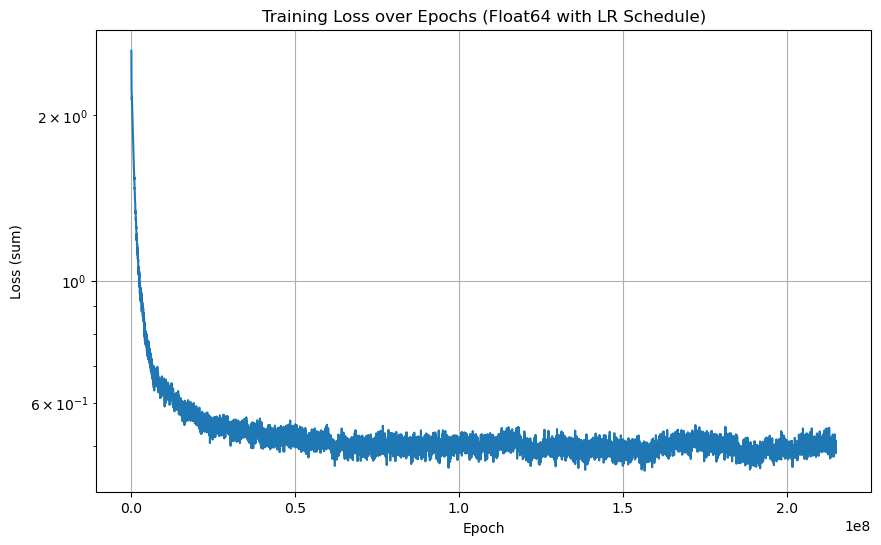

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_nums, losses / num_samples)
plt.xlabel('Epoch')
plt.ylabel('Loss (sum)')
plt.title('Training Loss over Epochs (Float64 with LR Schedule)')
plt.grid(True)
plt.yscale('log')
plt.show()

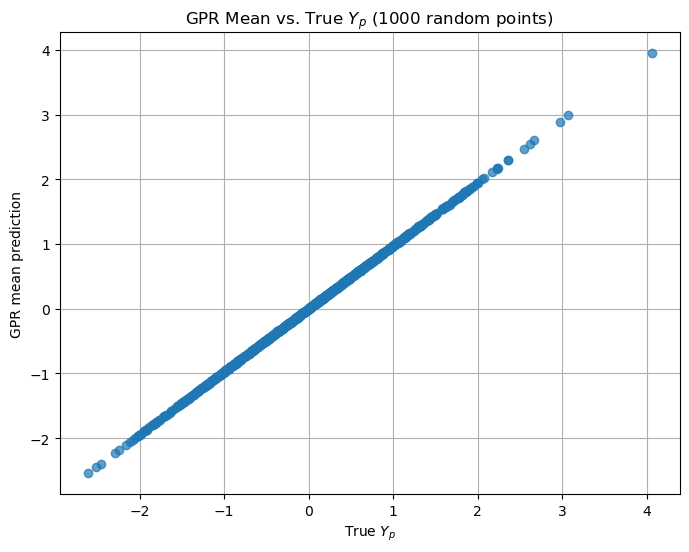

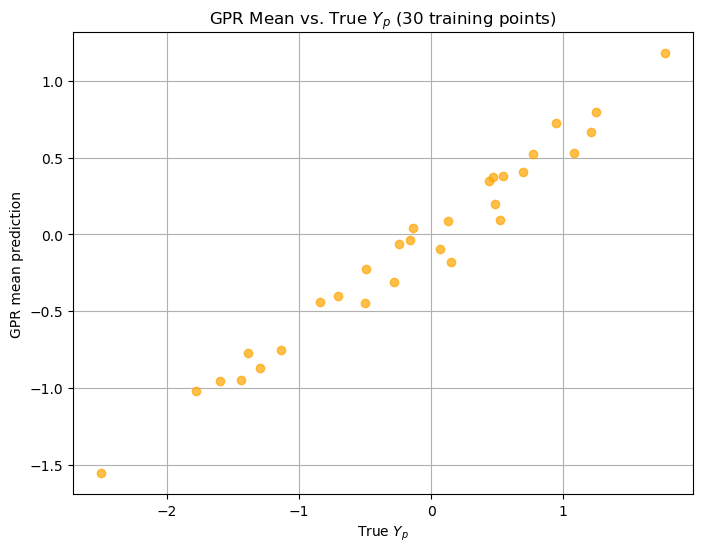

In [10]:
import torch
from GPKit import gpr_dot_product_explicit

# Plot 1: Xp with 1000 random points
Xp_1000 = torch.randn((1000, input_size), dtype=torch.float64).to(device)
Yp_1000 = Xp_1000[:,0].unsqueeze(-1).to(device)
gpr_mean_1000 = gpr_dot_product_explicit(Xp_1000, Yp_1000, Xp_1000, 1.0).cpu().detach()

plt.figure(figsize=(8, 6))
plt.plot(Yp_1000.cpu().numpy(), gpr_mean_1000.cpu().numpy(), 'o', alpha=0.7)
plt.xlabel('True $Y_p$')
plt.ylabel('GPR mean prediction')
plt.title('GPR Mean vs. True $Y_p$ (1000 random points)')
plt.grid(True)
plt.show()

# Plot 2: Xp with 30 training points (use X and Y from training data)
Xp_30 = X[:30]
Yp_30 = Y[:30]
gpr_mean_30 = gpr_dot_product_explicit(Xp_30, Yp_30, Xp_30, 1.0).cpu().detach()

plt.figure(figsize=(8, 6))
plt.plot(Yp_30.cpu().numpy(), gpr_mean_30.cpu().numpy(), 'o', alpha=0.7, color='orange')
plt.xlabel('True $Y_p$')
plt.ylabel('GPR mean prediction')
plt.title('GPR Mean vs. True $Y_p$ (30 training points)')
plt.grid(True)
plt.show()


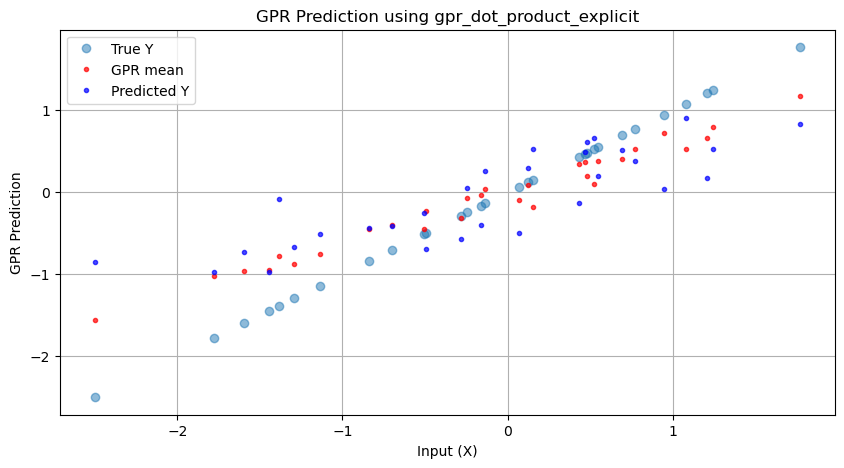

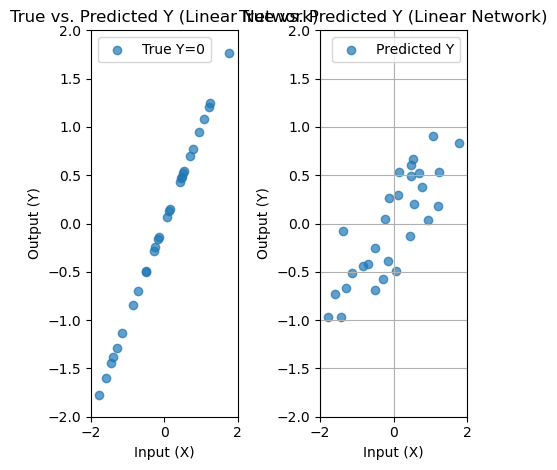

In [ ]:
pred = model(X).cpu().detach()

# 4. Visualize Results
model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_Y = pred.mean(axis=2).numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 3, 1)
# plt.plot(losses)
# plt.title('Loss over Epochs (Linear Network)')
# plt.xlabel('Epoch')
from GPKit import gpr_dot_product_explicit

# Compute the GPR prediction using the explicit dot product method
# X: (P, d), Y: (P, 1), pred: (P, 1, ens) or (P, ens)
# We'll use the training data for demonstration; for true GPR, use test points
X_np = X.cpu().detach().numpy()
Y_np = Y.cpu().detach().numpy().reshape(-1)
sigma_n = k  # data noise parameter, from training script

# Compute GPR mean and variance at training points
gpr_mean = gpr_dot_product_explicit(X, Y, X, 1.0).cpu().detach()

plt.figure(figsize=(10, 5))
plt.plot(X_np[:,0], Y_np, 'o', label='True Y', alpha=0.5)
plt.plot(X_np[:,0], gpr_mean, 'r.', label='GPR mean', alpha=0.7)
plt.plot(X[:,0].cpu().detach().numpy(), predicted_Y, 'b.',label='Predicted Y', alpha=0.7)

plt.xlabel('Input (X)')
plt.ylabel('GPR Prediction')
plt.title('GPR Prediction using gpr_dot_product_explicit')
plt.legend()
plt.grid(True)
plt.show()

plt.subplot(1, 3, 2)
plt.scatter(X[:,0].cpu().detach().numpy(), Y.cpu().detach().numpy(), label='True Y=0', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X[:,0].cpu().detach().numpy(), predicted_Y, label='Predicted Y', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# print("\nModel learned parameters (Linear Network with Langevin Dynamics):")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: {param.data.numpy()}")

In [7]:
y_tru = X[:,0].detach().cpu().numpy()
np.var((predicted_Y-y_tru)**2)

2.991401659997205

In [8]:
P_inf = 5000
X_inf = torch.randn((P_inf, input_size), dtype=torch.float64, device=device)
Y_inf = X_inf
lH, lHstd = model.H_eig(X_inf, Y_inf, std = True)

torch.Size([250, 7, 25])


In [9]:
hh_inf_i.shape

NameError: name 'hh_inf_i' is not defined

In [10]:

# Kernel is averaged over ensemble and neuron indices
f_inf = model.h1_preactivation(X_inf)
hh_inf_i = torch.einsum('uim,vim->uvi', f_inf, f_inf)/(hidden_size * P_inf) 
hh_inf = torch.sum(hh_inf_i, axis=2) / ens

norm = torch.einsum('ij,ij->j',X_inf.squeeze(), X_inf.squeeze()) / P_inf

Ls_i = torch.einsum('uj,uvi,vj->ij', X_inf.squeeze(), hh_inf_i, X_inf.squeeze()) / P_inf
lsT_i = Ls_i/norm

std_ls = torch.std(lsT_i, axis=0)


# Large matrix projection 
Ls = torch.einsum('uj,uv,vj->j', X_inf.squeeze(), hh_inf, X_inf.squeeze()) / P_inf



lsT = Ls/norm
lsT = lsT.detach().cpu().numpy()
lsT

array([0.11949016, 0.01678586, 0.01427226, 0.01562856, 0.01667615,
       0.01573371, 0.01622332, 0.01530519, 0.01764648, 0.01535594,
       0.01485053, 0.01642171, 0.0147556 , 0.02118326, 0.02068143,
       0.01665137, 0.01500506, 0.01834485, 0.01809253, 0.01476353,
       0.01473363, 0.01519235, 0.01693229, 0.01572431, 0.017419  ])

In [11]:
torch.std(lsT_i,axis=0)

tensor([0.0069, 0.0021, 0.0015, 0.0016, 0.0017, 0.0015, 0.0025, 0.0018, 0.0019,
        0.0015, 0.0012, 0.0016, 0.0005, 0.0019, 0.0027, 0.0022, 0.0016, 0.0024,
        0.0010, 0.0015, 0.0011, 0.0018, 0.0023, 0.0018, 0.0018],
       grad_fn=<StdBackward0>)

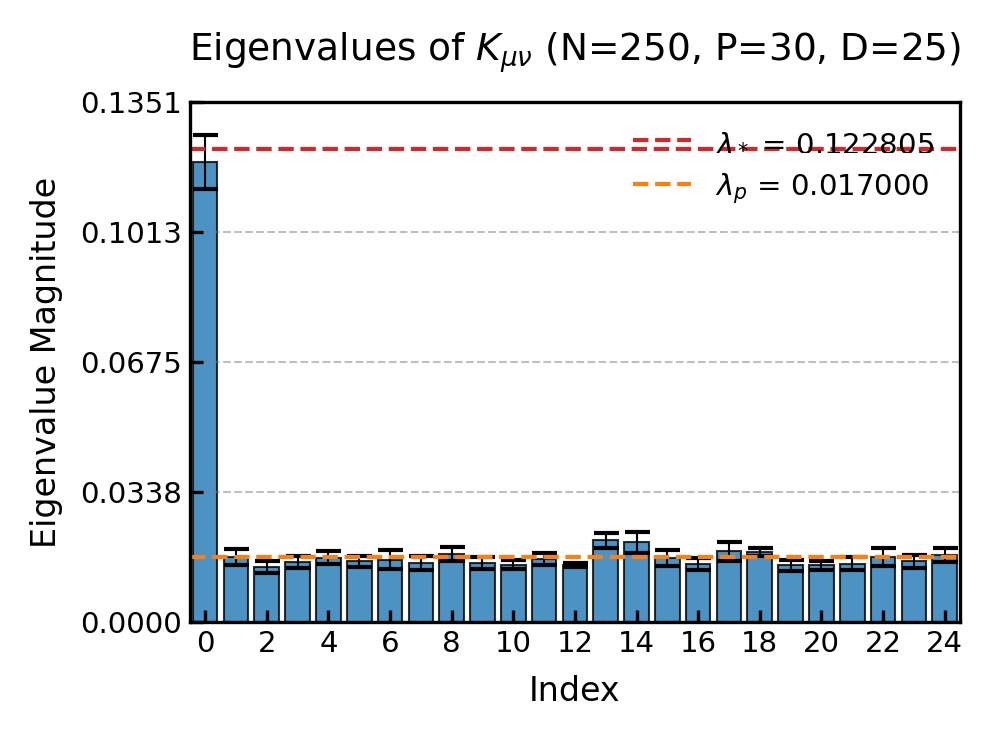

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assume all variables are defined as in the original code:
# x = range(len(lsT))
# lsT_arr = np.array(lH.detach().cpu().numpy())
# std_ls_arr = np.array(std_ls.detach().cpu().numpy())
# hidden_size, num_samples, input_size, ltarg, l_GP are defined
l_GP = 0.017
ltarg = 0.122805

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Assume all variables are defined as in the original code:
x = range(len(lsT))
lsT_arr = np.array(lH.detach().cpu().numpy())
std_ls_arr = np.array(std_ls.detach().cpu().numpy())
# hidden_size, num_samples, input_size, ltarg, l_GP are defined

# Set Nature-style figure parameters
plt.style.use('default')  # Reset to default style

# Check for Arial font, fall back to DejaVu Sans if not found
available_fonts = [f.name for f in fm.fontManager.ttflist]
font_family = 'Arial' if 'Arial' in available_fonts else 'DejaVu Sans'

plt.rcParams.update({
    'font.family': font_family,  # Use Arial or fallback
    'font.size': 8,  # Suitable for Nature (8-10 pt)
    'axes.linewidth': 0.8,  # Thinner lines for clarity
    'xtick.direction': 'in',  # Ticks inward
    'ytick.direction': 'in',
    'xtick.major.size': 3,  # Smaller ticks
    'ytick.major.size': 3,
    'figure.dpi': 300,  # High resolution for print
})

# Create figure with size suitable for single-column (8.5 cm ≈ 3.35 inches)
fig, ax = plt.subplots(figsize=(3.35, 2.5))  # Compact for journal

# Plot bars with error bars
bars = ax.bar(x, lsT_arr, yerr=std_ls_arr, capsize=3, color='#1f77b4',  # Muted blue
              edgecolor='black', linewidth=0.5, alpha=0.8, ecolor='black', error_kw={'capsize': 3, 'lw': 0.5})

# Add horizontal lines
ax.axhline(y=ltarg, color='#d62728', linestyle='--', linewidth=1, label=f'$\lambda_*$ = {ltarg:.6f}')
ax.axhline(y=l_GP, color='#ff7f0e', linestyle='--', linewidth=1, label=f'$\lambda_p$ = {l_GP:.6f}')

# Customize axes
ax.set_xlabel('Index', fontsize=8)
ax.set_ylabel('Eigenvalue Magnitude', fontsize=8)
ax.set_title(f'Eigenvalues of $K_{{\\mu\\nu}}$ (N={hidden_size}, P={num_samples}, D={input_size})',
             fontsize=9, pad=10)

# Set axis limits
Ymax = max(lsT_arr.max(), ltarg, l_GP) * 1.1  # 10% above max for headroom
ax.set_ylim(0, Ymax)
ax.set_xlim(-0.5, len(x) - 0.5)  # Tight x-axis limits
ax.set_xticks(x[::2])  # Every other tick to avoid clutter
ax.set_yticks(np.linspace(0, Ymax, 5))  # 5 evenly spaced y-ticks

# Customize ticks and spines
ax.tick_params(axis='both', labelsize=7, pad=2)
for spine in ax.spines.values():
    spine.set_linewidth(0.8)

# Add grid
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Add legend
ax.legend(fontsize=7, loc='upper right', frameon=False)

# Tight layout to prevent clipping
plt.tight_layout()

# Save as high-resolution PDF for publication
plt.savefig('eigenvalues_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [13]:
lsT.tolist() + [.419]

[0.13731030047062145,
 0.02069887688961542,
 0.01790680517996945,
 0.019893619776229214,
 0.01925163195793978,
 0.02148583379105661,
 0.01735527669812067,
 0.01977503607216555,
 0.02068068680017837,
 0.017903700972975344,
 0.01840764004551774,
 0.018760717628360412,
 0.019205619257423086,
 0.02464425393697761,
 0.02638583115433537,
 0.019547244656438822,
 0.018772154728053086,
 0.02195749893844982,
 0.0215777453813259,
 0.019743118085353107,
 0.01804790781521489,
 0.01971797492102046,
 0.018718869286832647,
 0.020917607085752996,
 0.02038979334061819,
 0.419]

In [43]:
# Plot the histogram of the eigenvalues and overlay a Gaussian fit
import numpy as np
from scipy.stats import norm

eigenvalues = y
mean = np.mean(eigenvalues)
std = np.std(eigenvalues)

plt.figure(figsize=(8, 5))
# Plot histogram
counts, bins, patches = plt.hist(eigenvalues, bins=3, color='#5c4033', alpha=0.7, edgecolor='black', density=True, label='Histogram')

# Overlay Gaussian
# Set x limits far from the mean to emphasize the narrowness
xlim_pad = 10  # how many stds to pad on each side
x_min = mean - xlim_pad * std
x_max = mean + xlim_pad * std
x = np.linspace(x_min, x_max, 400)
pdf = norm.pdf(x, mean, std)
plt.plot(x, pdf, color='navy', linewidth=2, label=f'Gaussian ($\\mu$={mean:.3f}, $\\sigma$={std:.3f})')

plt.xlabel('Eigenvalue', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram of Eigenvalues', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=12)
plt.xlim(x_min, x_max)
plt.tight_layout()
plt.show()

NameError: name 'y' is not defined

In [43]:
losses

array([145.24236037, 139.52198146, 135.21983603, 130.08604029,
       125.47242027, 121.29294844, 117.6878342 , 113.893784  ,
       109.98220941, 106.71826585, 103.46336316, 101.17722142,
        97.61657394,  94.86406947,  92.9799073 ,  89.33813349,
        87.32173253,  86.42627129,  83.55865905,  82.5461606 ,
        80.10963727,  78.0632102 ,  76.36523891,  74.74391947,
        73.3913644 ,  72.01364941,  70.91725497,  69.50723108,
        68.46452357,  66.59878878,  65.33054497,  64.54091109,
        63.73588336,  63.08463108,  61.42861373,  60.81258523,
        59.85536671,  58.71789996,  57.91049948,  56.76801824,
        56.0779108 ,  55.71827063,  54.79328392,  54.38617479,
        53.54890313,  52.6903891 ,  52.4692266 ,  51.32005436,
        50.8573814 ,  50.43853251,  50.15992044,  48.88982971,
        48.71802397,  48.93317273,  48.05651071,  47.08230285,
        47.14521044,  46.6733864 ,  45.86665207,  45.88259474,
        45.28493762,  44.83193312,  44.20829114,  43.77

In [44]:
np.mean(ls)

0.08131752598306402

In [45]:
np.std(ls)

0.007212632036172995

In [46]:
epoch > 2_000_000 * 0.8

True

In [45]:
import sys
sys.path.append('/home/akiva/FCNX-Ensembling/')

from GPKit import *
true_gpr = gpr_dot_product_explicit(X, Y, X, 1.0).cpu().detach()
prediction = model(X).cpu().detach().mean(-1)
tru_y =  Y.cpu().cpu().detach()
prediction.shape

torch.Size([30, 1])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

tru_y_np shape: (30, 1)
true_gpr_np shape: (30, 1)
prediction_np_cpu shape: (30, 1)
X_np shape: (30, 25)
MSE similarity between true_gpr_np and prediction_np: -0.0012795722441795092
MSE similarity between prediction_np and tru_y_np: 0.0026532208069898226
MSE similarity between true_gpr_np and tru_y: 0.0013736485628103139


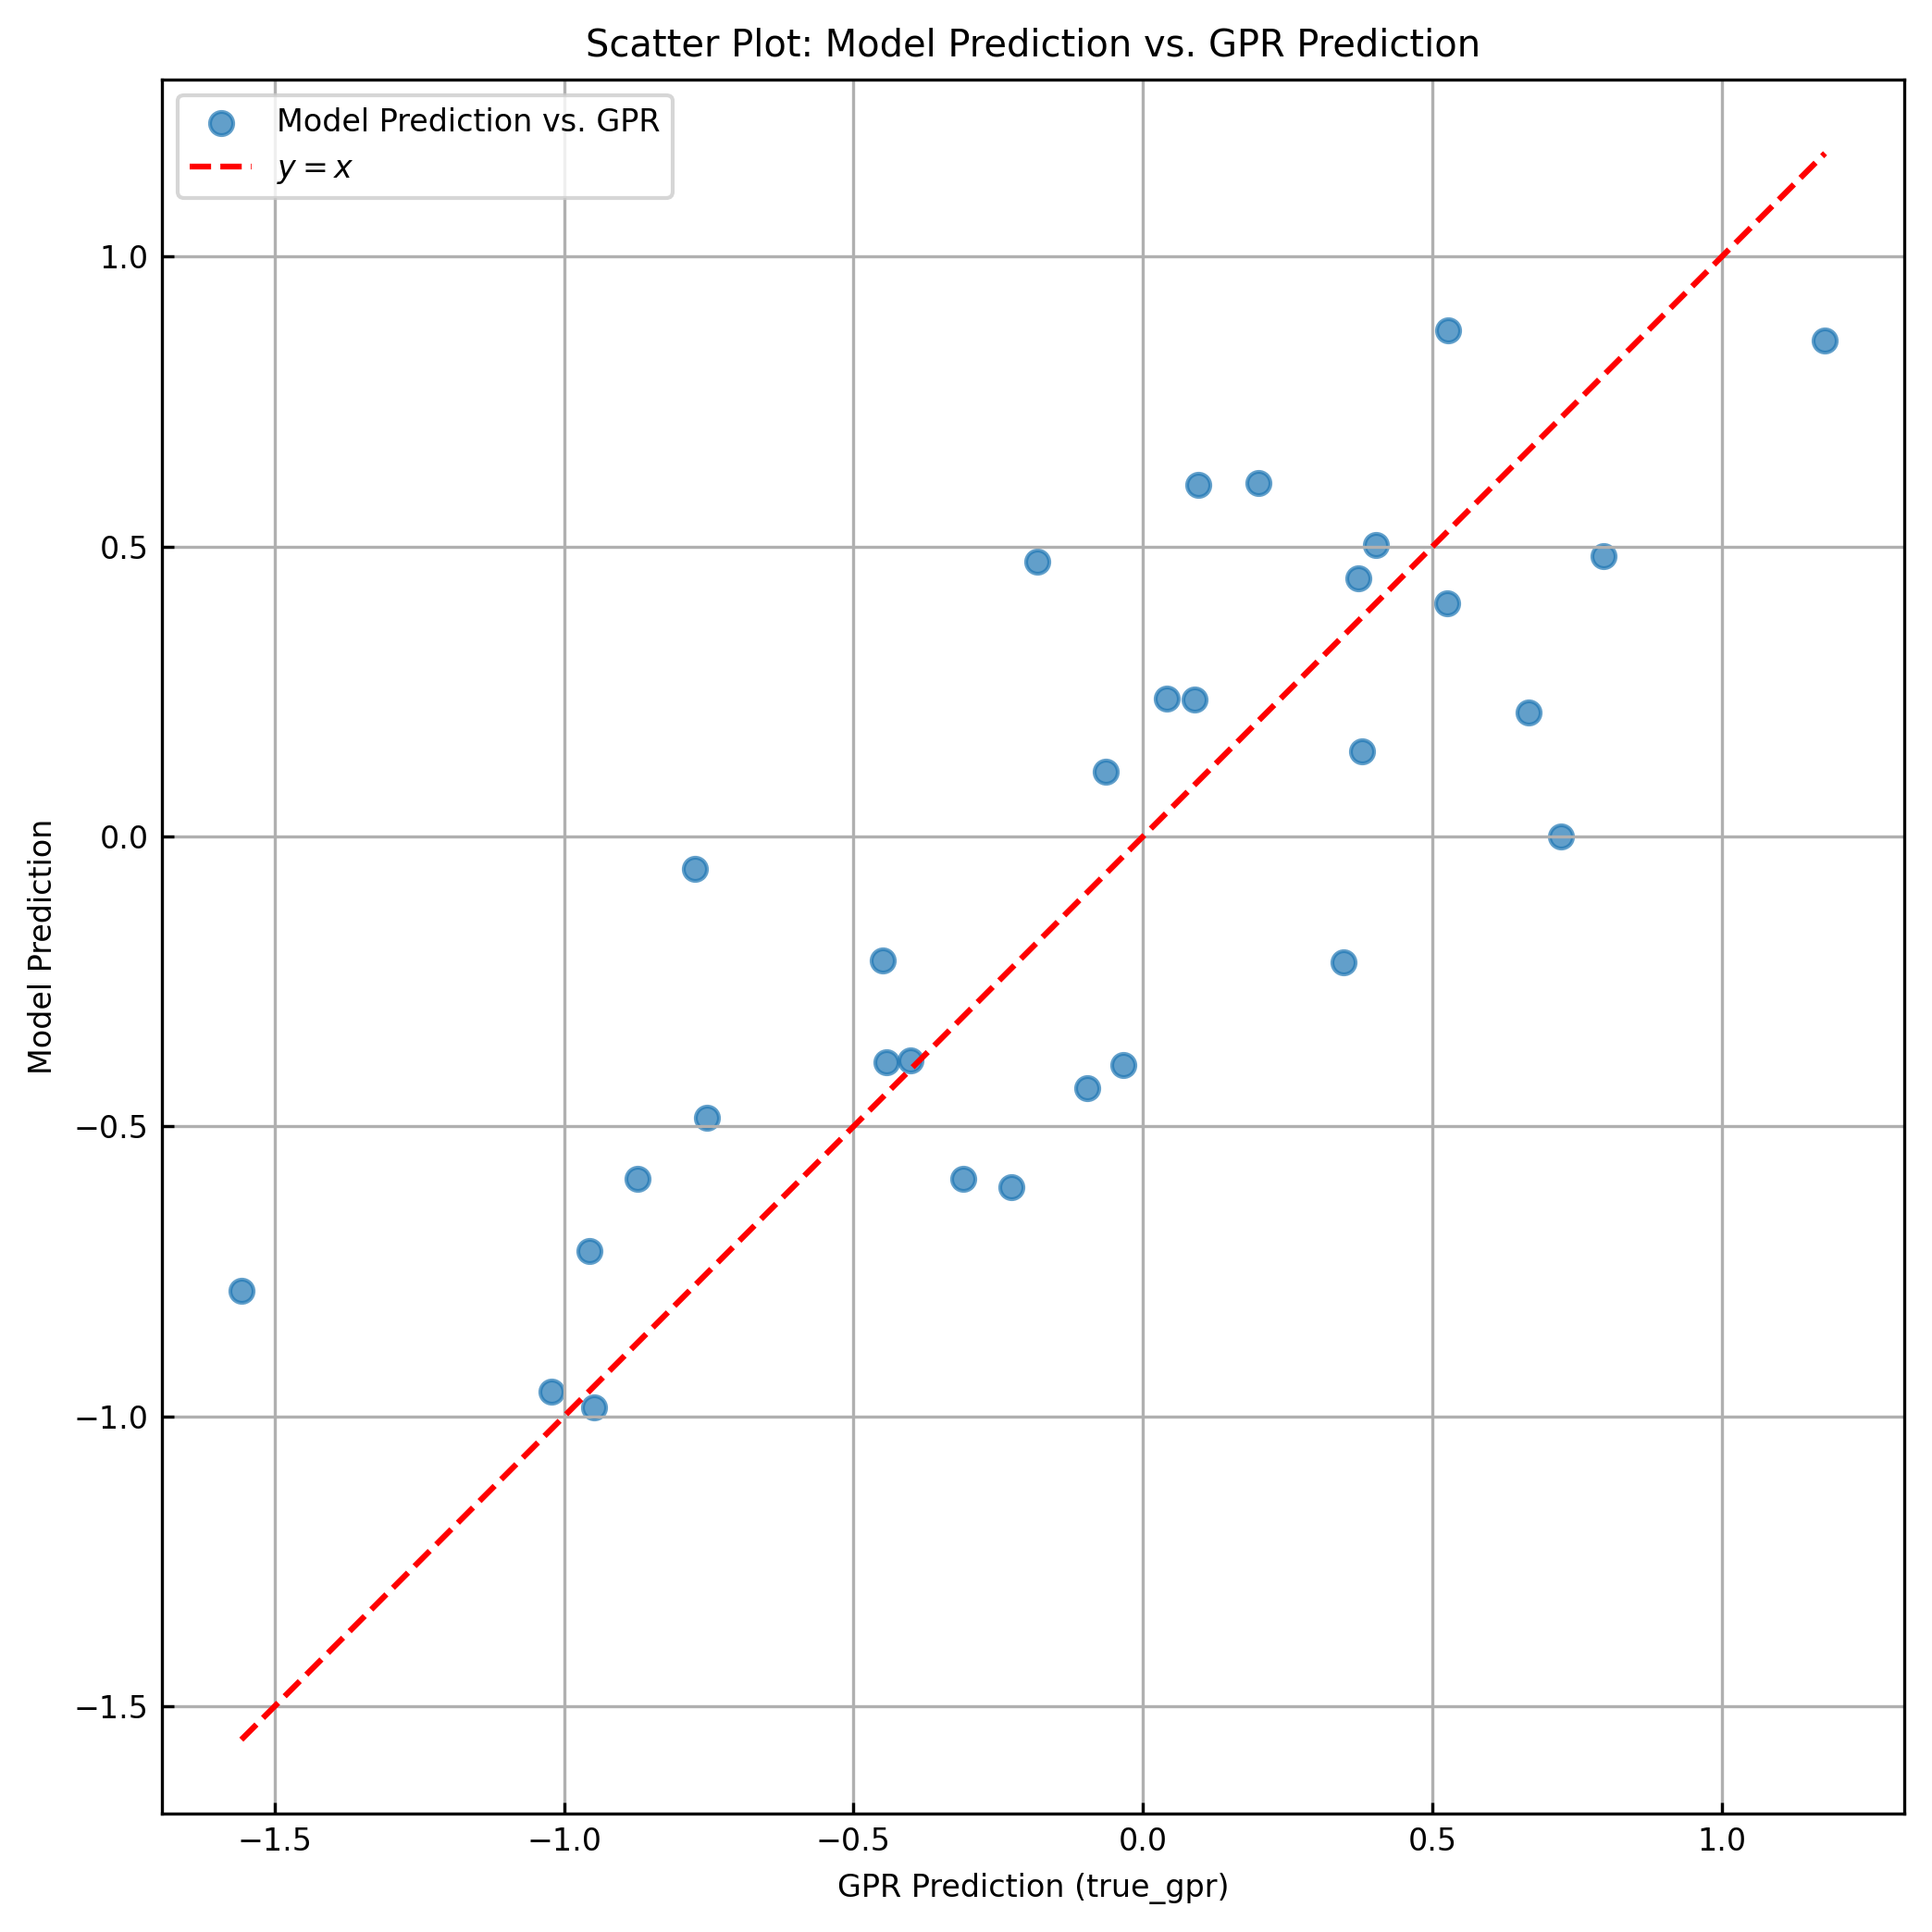

In [46]:


# Move all data to CPU numpy arrays
tru_y_np = tru_y.numpy() if hasattr(tru_y, 'cpu') else tru_y
true_gpr_np = true_gpr.cpu().numpy() if hasattr(true_gpr, 'cpu') else true_gpr
prediction_np = prediction.cpu().numpy() if hasattr(prediction, 'cpu') else prediction
X_np = X.cpu().detach().numpy() if hasattr(X, 'cpu') else X

# Print shapes of all these arrays/tensors
print("tru_y_np shape:", getattr(tru_y_np, "shape", "no shape"))
print("true_gpr_np shape:", getattr(true_gpr_np, "shape", "no shape"))
print("prediction_np_cpu shape:", getattr(prediction_np, "shape", "no shape"))
print("X_np shape:", getattr(X_np, "shape", "no shape"))



def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two numpy arrays.
    """
    a_flat = a.ravel()
    b_flat = b.ravel()
    numerator = np.dot(a_flat, b_flat)
    denominator = np.linalg.norm(a_flat) * np.linalg.norm(b_flat)
    cossim = numerator / denominator if denominator != 0 else np.nan
    return np.arccos(cossim) * 180 / np.pi 

def me(a,b):
    return np.mean((a - b))  / num_samples

# Compute cosine similarity between true_gpr_np and prediction_np

mse_nn_gpr = me(true_gpr_np, prediction_np) 
print("MSE similarity between true_gpr_np and prediction_np:", mse_nn_gpr)

# Compute cosine similarity between true_gpr_np and tru_y
mse_nn_truy = me(prediction_np, tru_y_np) 
print("MSE similarity between prediction_np and tru_y_np:", mse_nn_truy)

# Compute cosine similarity between true_gpr_np and tru_y
mse_gpr_truy = me(true_gpr_np, tru_y_np) 
print("MSE similarity between true_gpr_np and tru_y:", mse_gpr_truy)
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Flatten arrays if needed for scatter plot
gpr_flat = true_gpr.flatten()
pred_flat = prediction_np.flatten()

plt.figure(figsize=(7, 7))
plt.scatter(gpr_flat, pred_flat, alpha=0.7, label='Model Prediction vs. GPR')
min_val = min(gpr_flat.min(), pred_flat.min())
max_val = max(gpr_flat.max(), pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y=x$')
plt.xlabel('GPR Prediction (true_gpr)')
plt.ylabel('Model Prediction')
plt.title('Scatter Plot: Model Prediction vs. GPR Prediction')
plt.legend()
plt.axis('equal')  # Keep x and y axis with the same scale
plt.grid(True)
plt.tight_layout()
plt.show()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

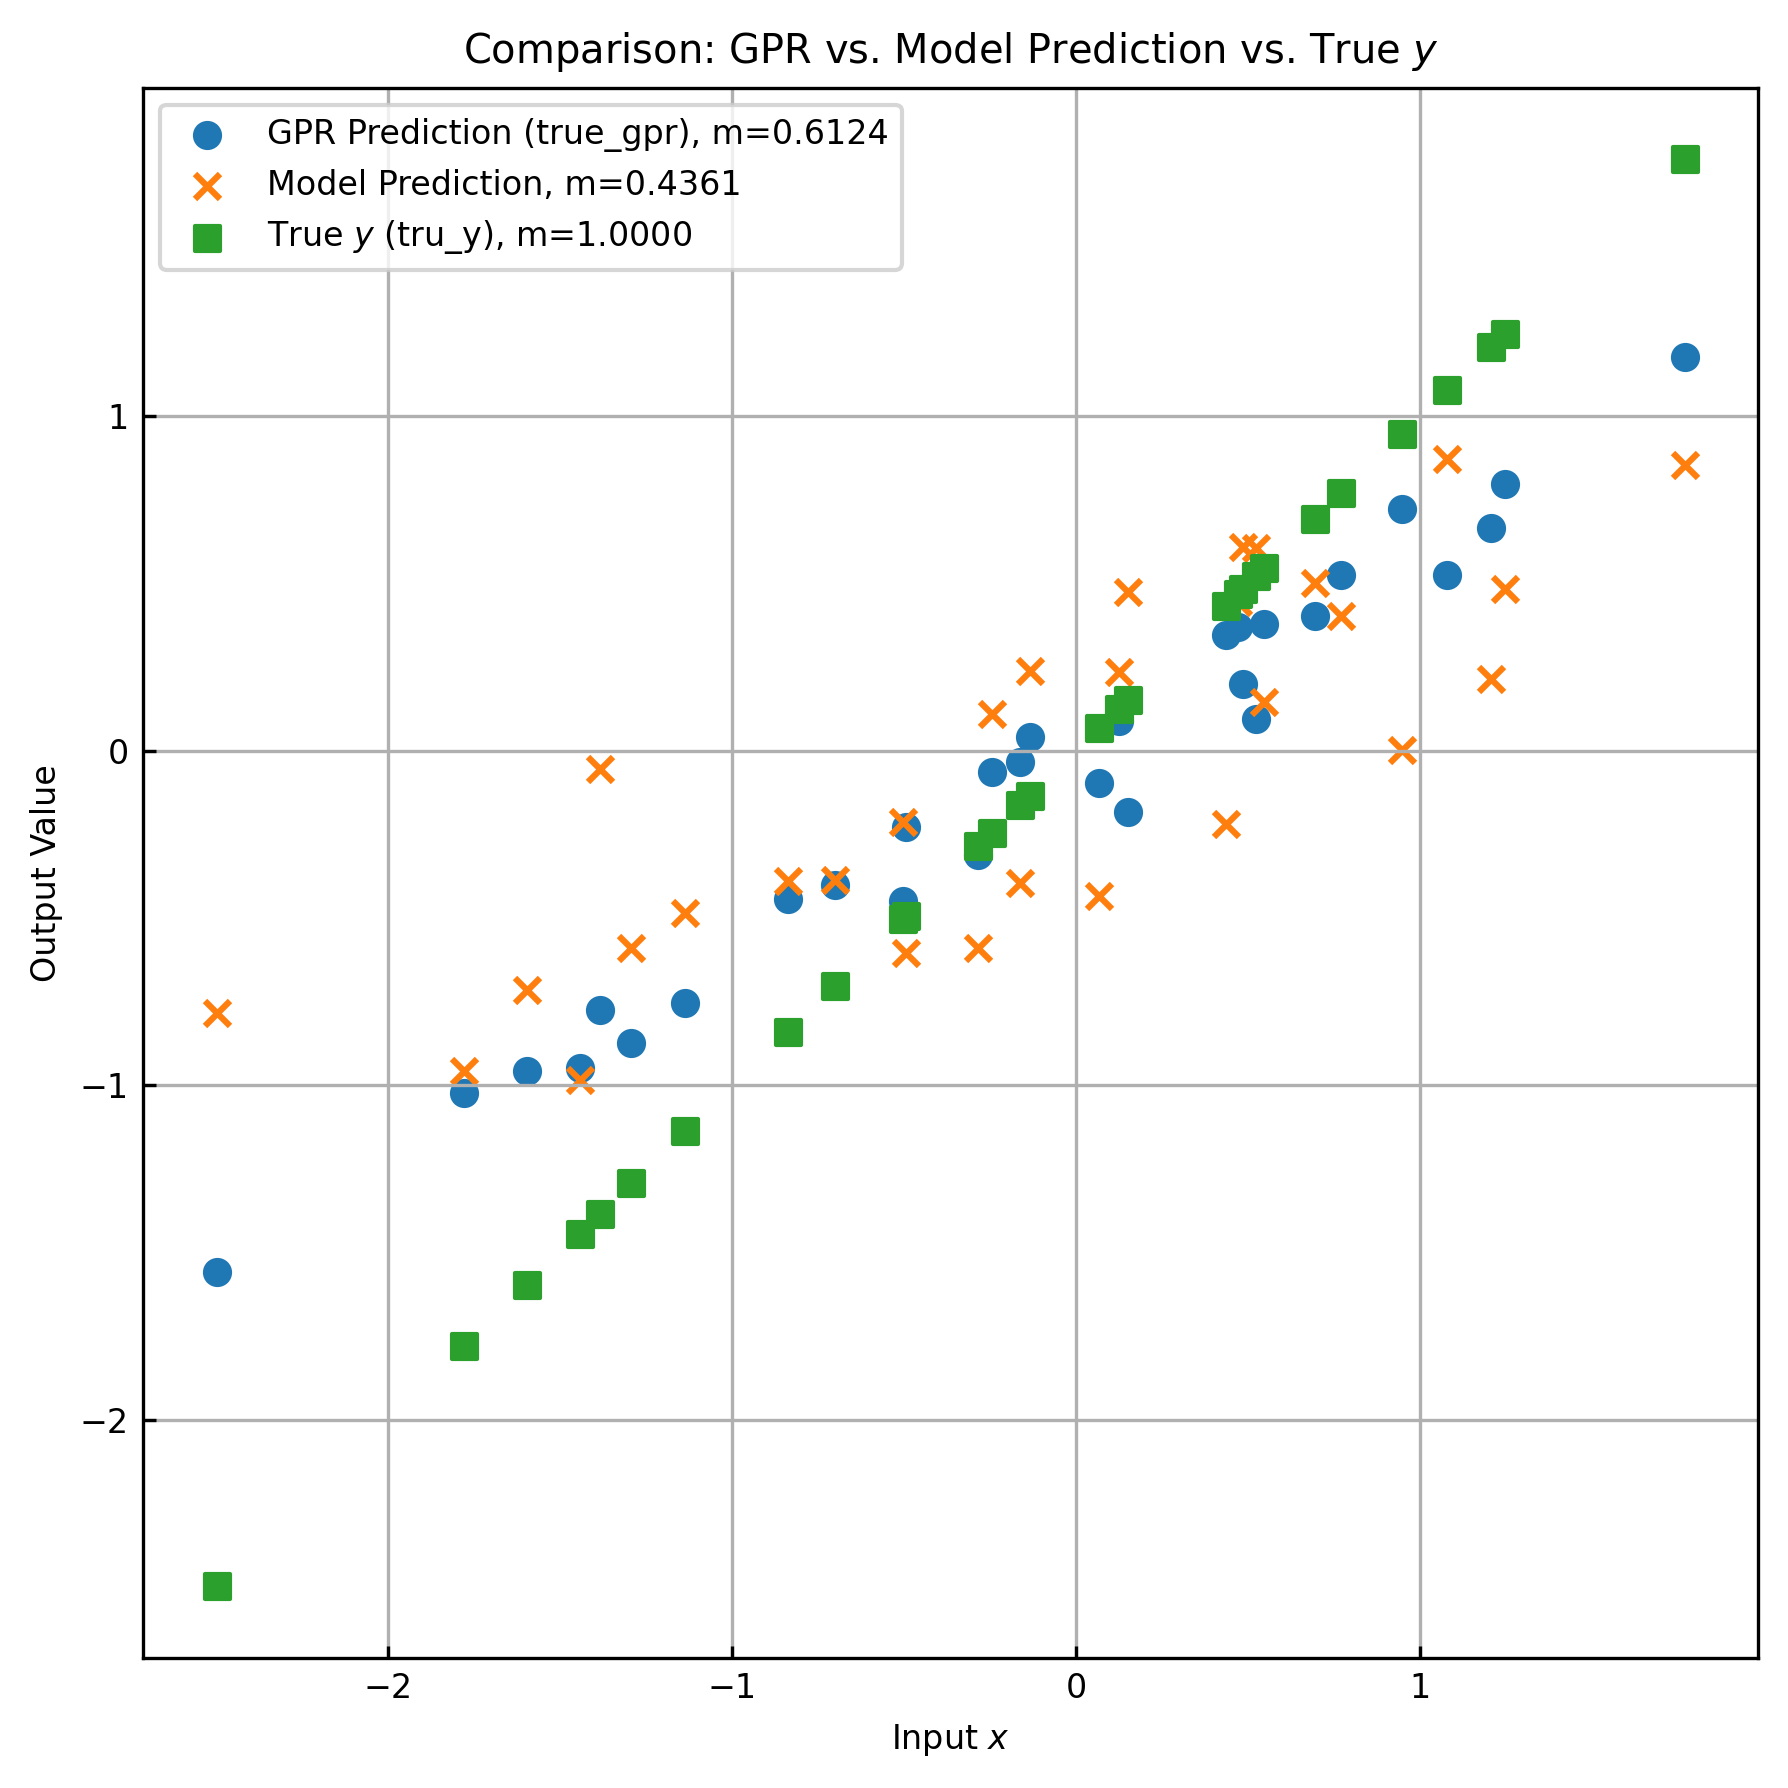

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

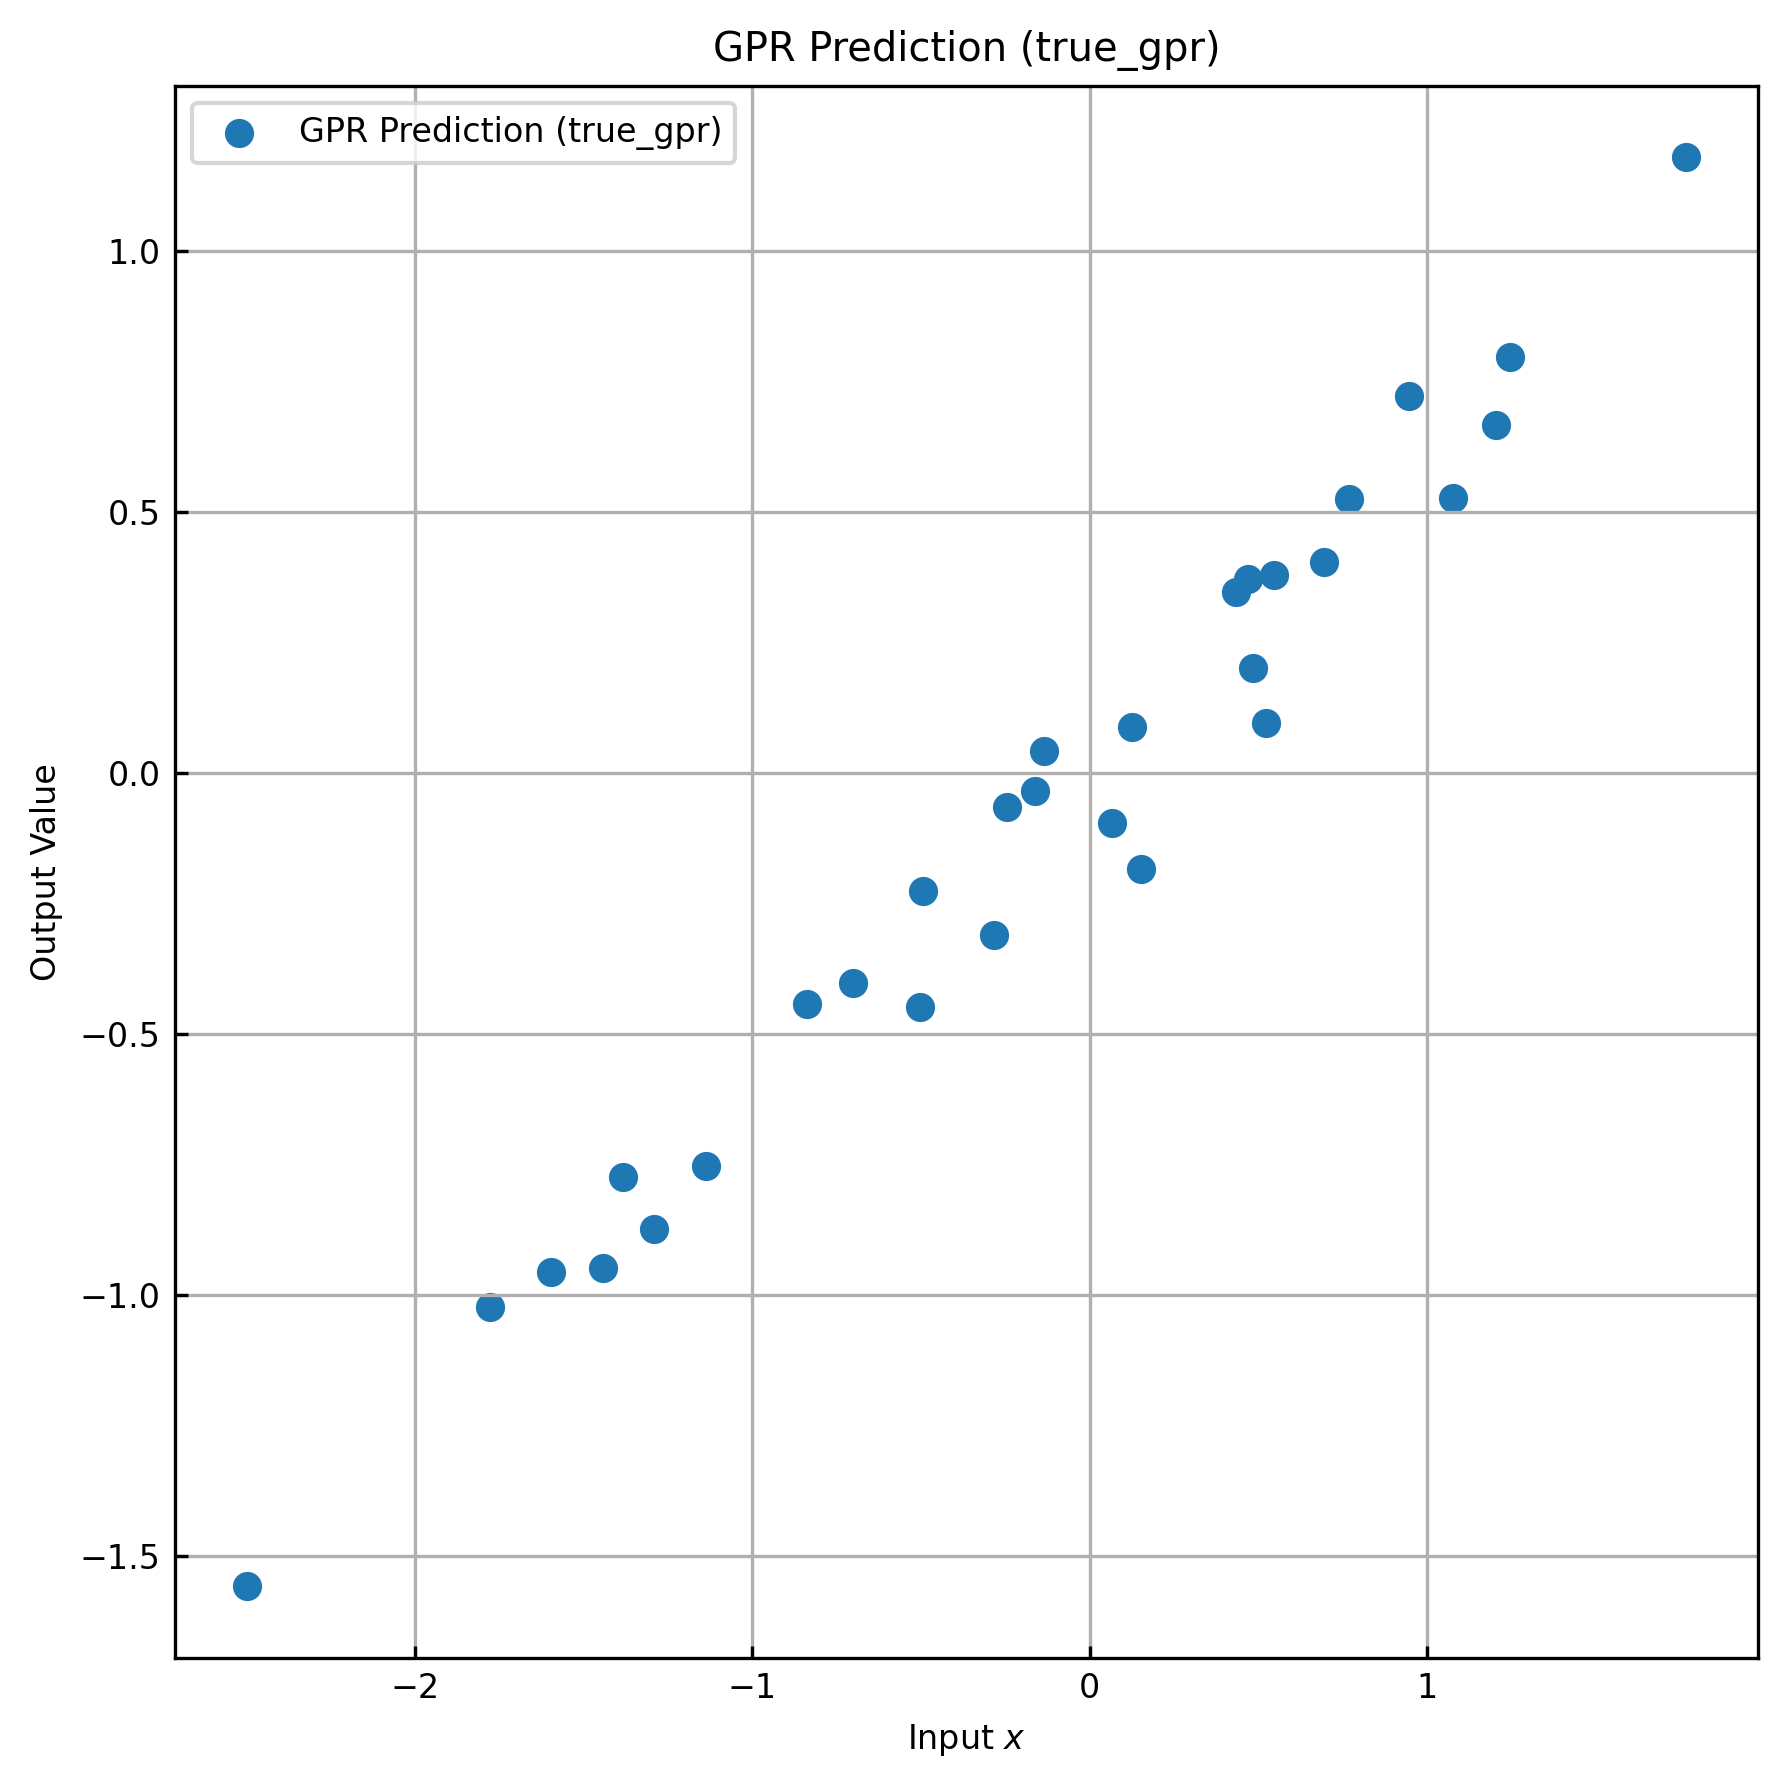

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

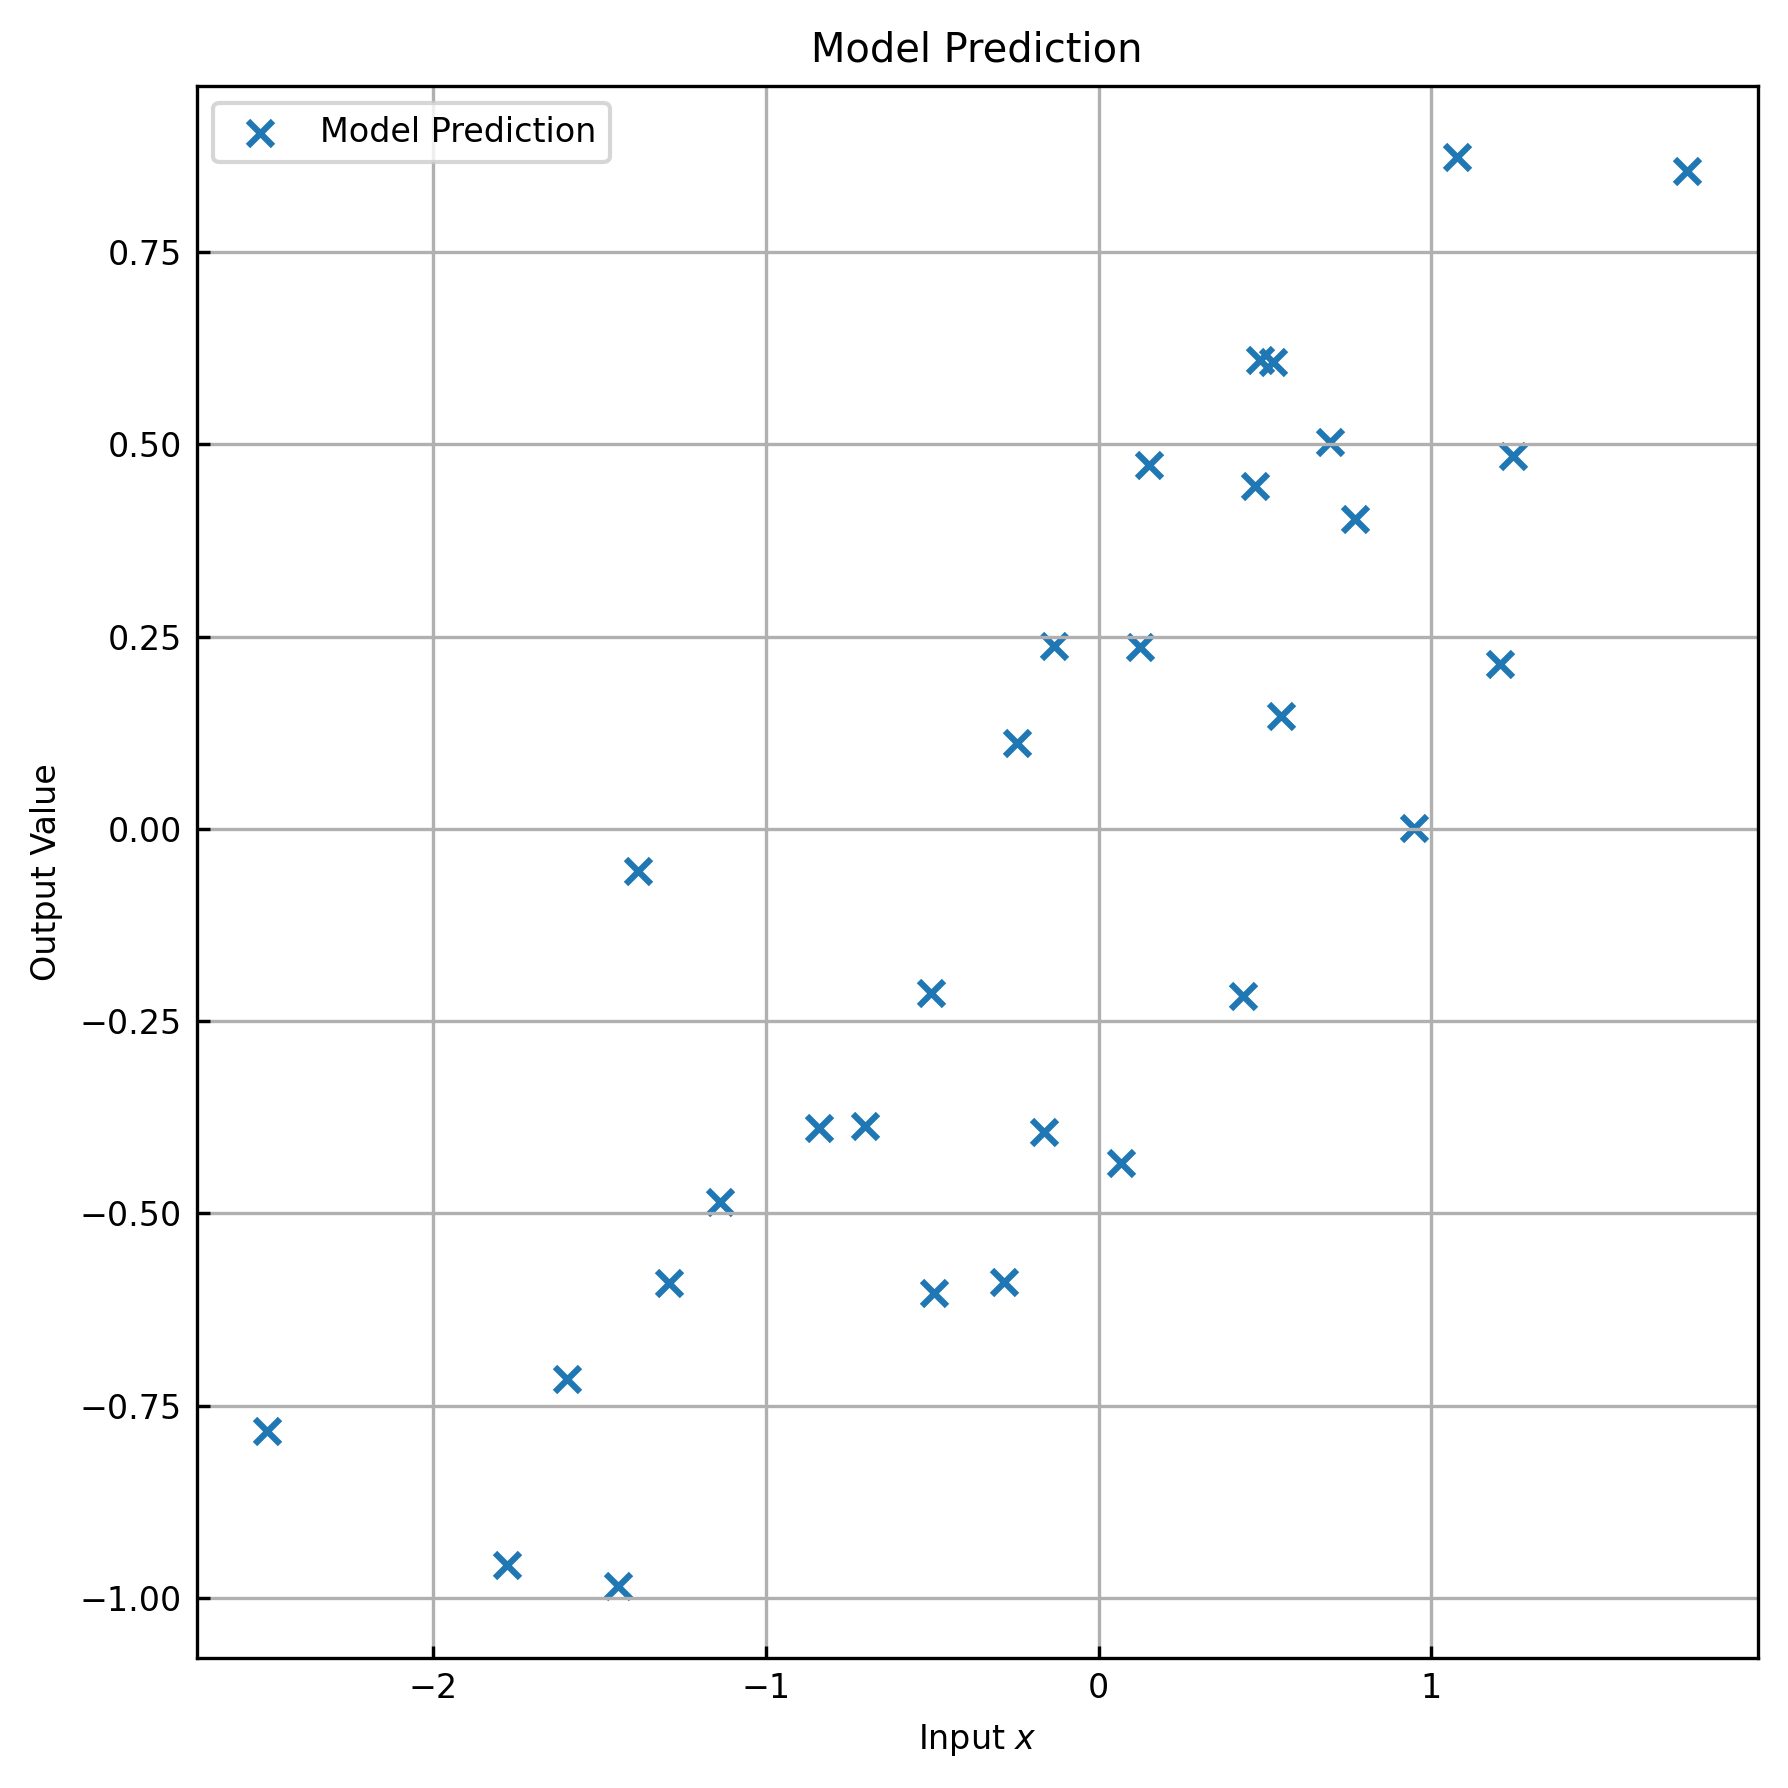

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

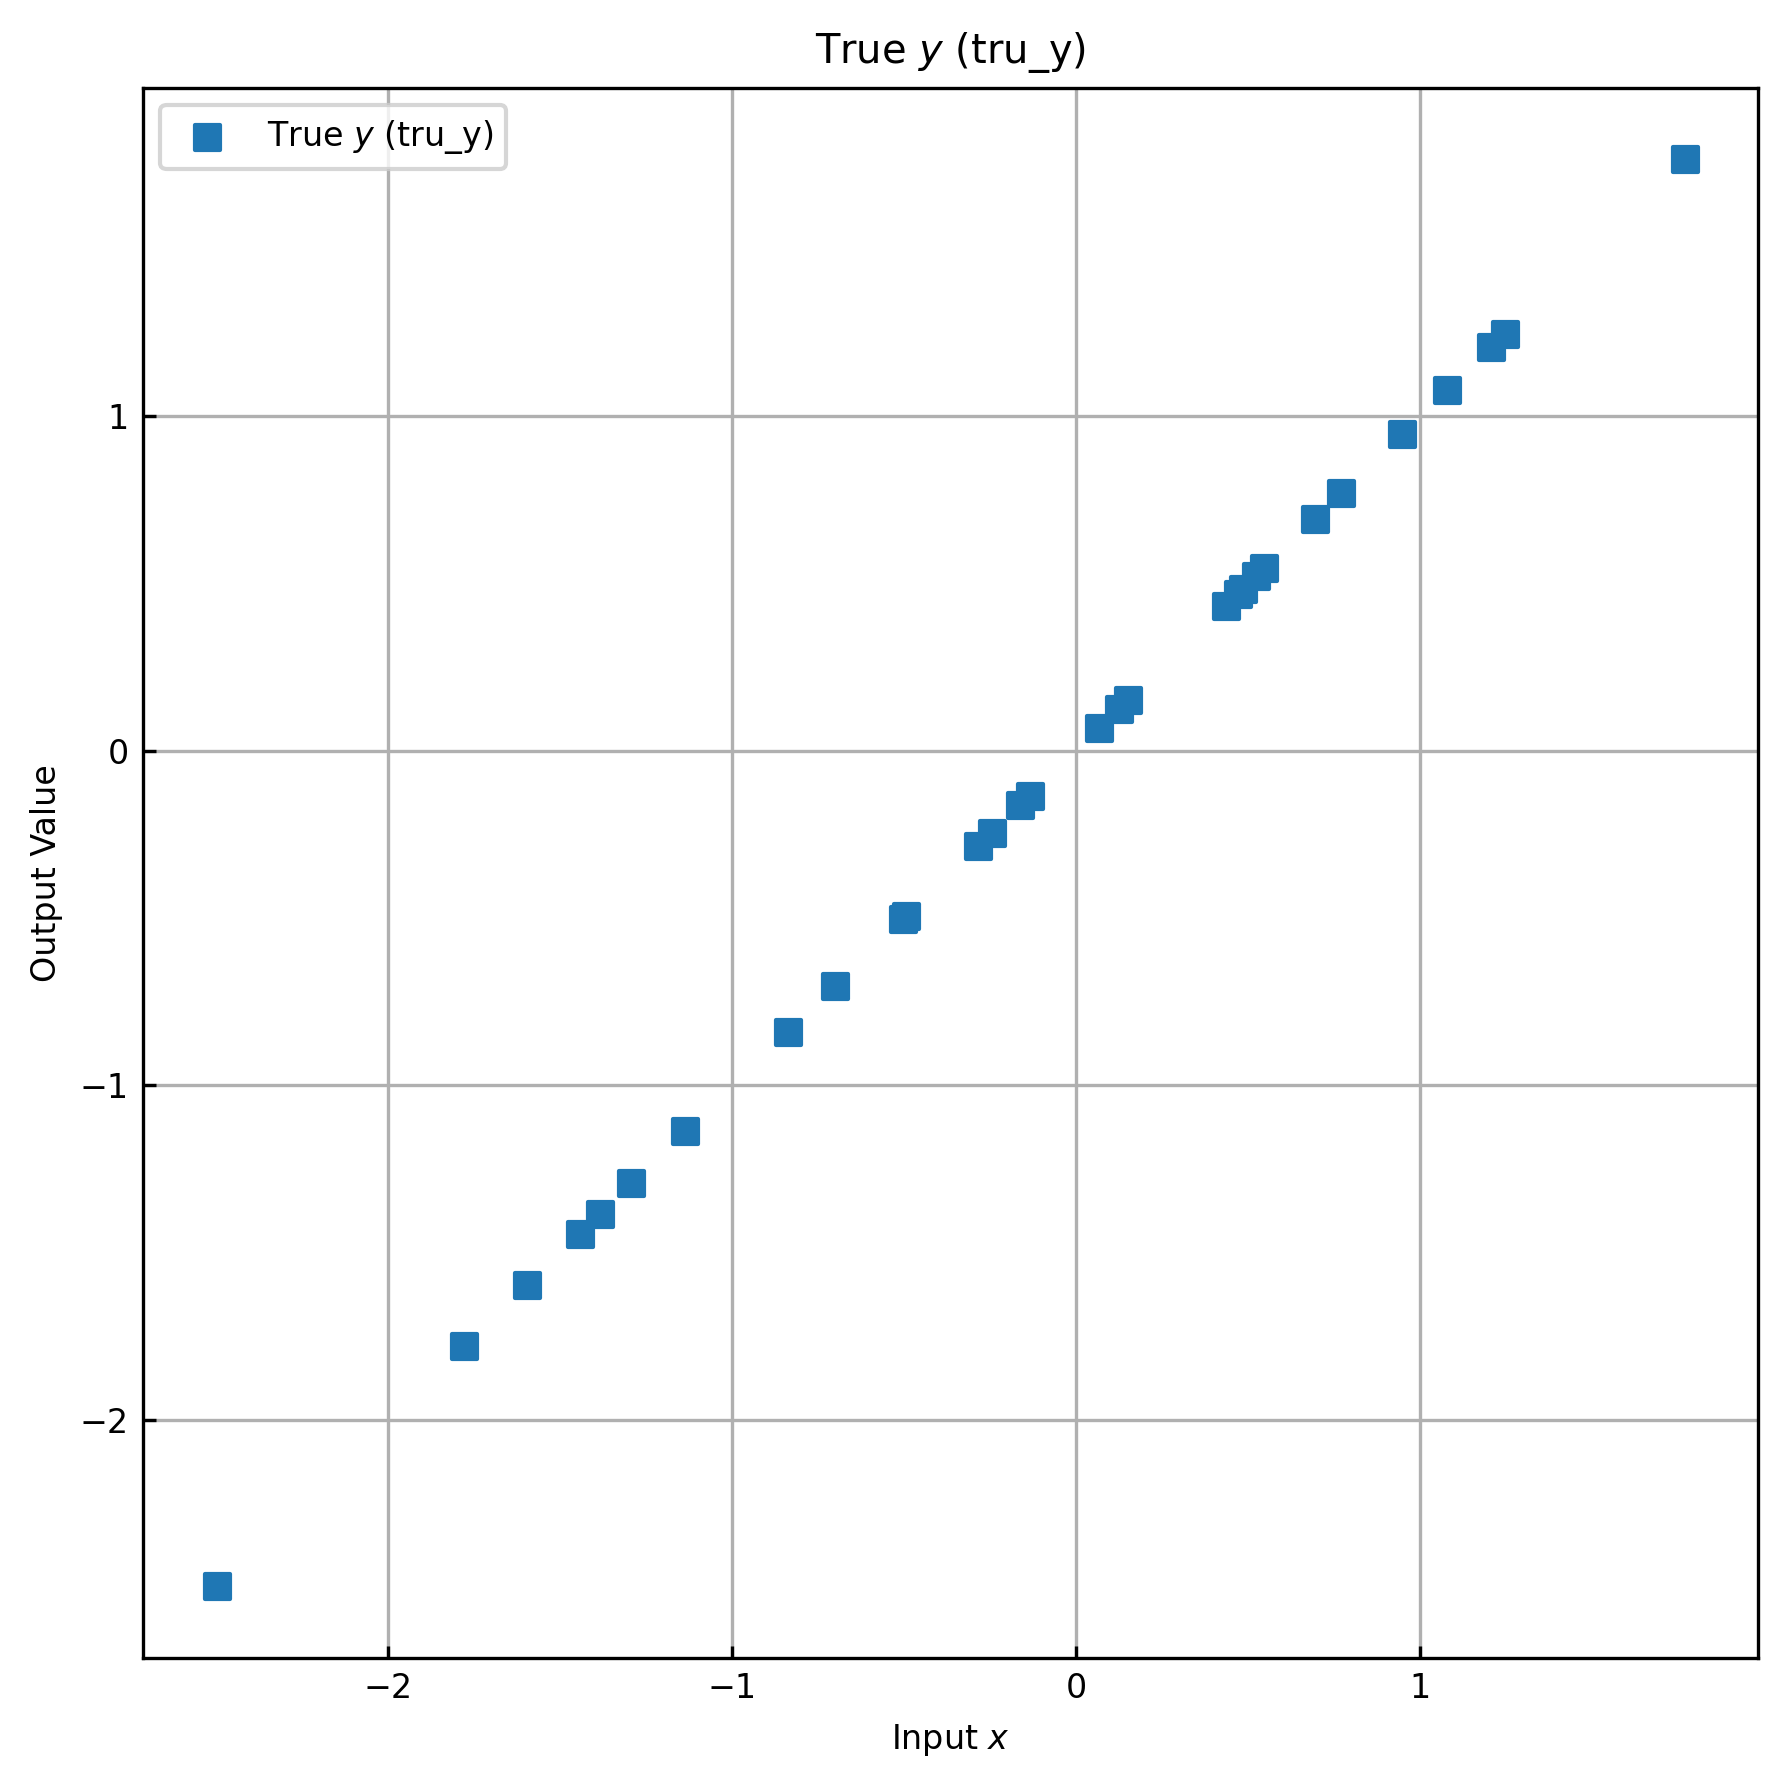

In [47]:
slope = lambda x, y: np.polyfit(x, y, 1)[0].item() if len(x) == len(y) else None
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Use x[:,0] as the x-axis for plotting
if hasattr(X, "detach"):
    x_plot = X.detach().cpu().numpy()
else:
    x_plot = np.array(X)
x_axis = x_plot[:,0] if x_plot.ndim > 1 else x_plot

# Plot comparison of true_gpr, prediction, and tru_y
plt.figure(figsize=(6, 6))
s1 = slope(x_axis, true_gpr)
s2 = slope(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np)
s3 = slope(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y)
plt.scatter(x_axis, true_gpr, label=f'GPR Prediction (true_gpr), m={s1:.4f}', marker='o')
plt.scatter(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np, label=f'Model Prediction, m={s2:.4f}', marker='x')
plt.scatter(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y, label=f'True $y$ (tru_y), m={s3:.4f}', marker='s')


plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Comparison: GPR vs. Model Prediction vs. True $y$')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Plot each curve in a separate figure, one beneath the other

# Plot 1: GPR Prediction (true_gpr)
plt.figure(figsize=(6, 6))
plt.scatter(x_axis, true_gpr, label='GPR Prediction (true_gpr)', marker='o')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('GPR Prediction (true_gpr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Model Prediction
plt.figure(figsize=(6, 6))
plt.scatter(x_axis, prediction_np[:,0] if prediction_np.ndim > 1 else prediction_np, label='Model Prediction', marker='x')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Model Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: True y (tru_y)



plt.figure(figsize=(6, 6))
plt.scatter(x_axis, tru_y[:,0] if tru_y.ndim > 1 else tru_y, label='True $y$ (tru_y)', marker='s')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('True $y$ (tru_y)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
getslope = lambda x, y: np.polyfit(x, y, 1)[0].item() if len(x) == len(y) else None

import os
import torch
import re
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm


model_dir = file
epochs = []
slopes = []
cosine_similarities = []
X.requires_grad_(True)

for filename in os.listdir(model_dir):
    if filename.startswith("model_epoch_") and filename.endswith(".pth"):
        filepath = os.path.join(model_dir, filename)
        match = re.search(r"model_epoch_(\d+)\.pth", filename)
        if match:
            epoch = int(match.group(1))
            epochs.append(epoch)
            model.load_state_dict(torch.load(filepath, map_location=device))
            model.eval()
            X_clone = X.clone()
            output = model(X_clone).mean(axis=-1).to('cpu').detach().numpy()
            slope = getslope(true_gpr_np[:,0], output[:,0])
            slopes.append(slope)
            # Compute cosine similarity of model output against true_gpr_np
            model_output_flat = output.flatten()
            true_gpr_flat = true_gpr_np[:,0].flatten()
            cosine_similarity = np.dot(model_output_flat, true_gpr_flat) / (norm(model_output_flat) * norm(true_gpr_flat))
            cosine_similarities.append(cosine_similarity)




In [50]:
sorted_indices = np.argsort(epochs)
epochs_sorted = np.array(epochs)[sorted_indices]
slopes_sorted = np.array(slopes)[sorted_indices]
cos_sorted = np.array(cosine_similarities)[sorted_indices]

In [51]:
true_slope = getslope(X.to('cpu').detach().numpy()[:,0], Y.to('cpu').detach().numpy())
m_gpr = getslope(true_gpr_np[:,0], true_gpr_np[:,0])

In [52]:
tosave = {'Indices': sorted_indices, 'Epochs': epochs_sorted, 'Predicted Slopes':slopes_sorted, 'Cosine Similarity': cos_sorted }
import pickle
with open(os.path.join(file, 'gp_comparison_metrics_over_time'), 'wb') as f:
    pickle.dump(tosave, f)

Text(0.02, 0.98, 'Recorded on 20250910_143800')

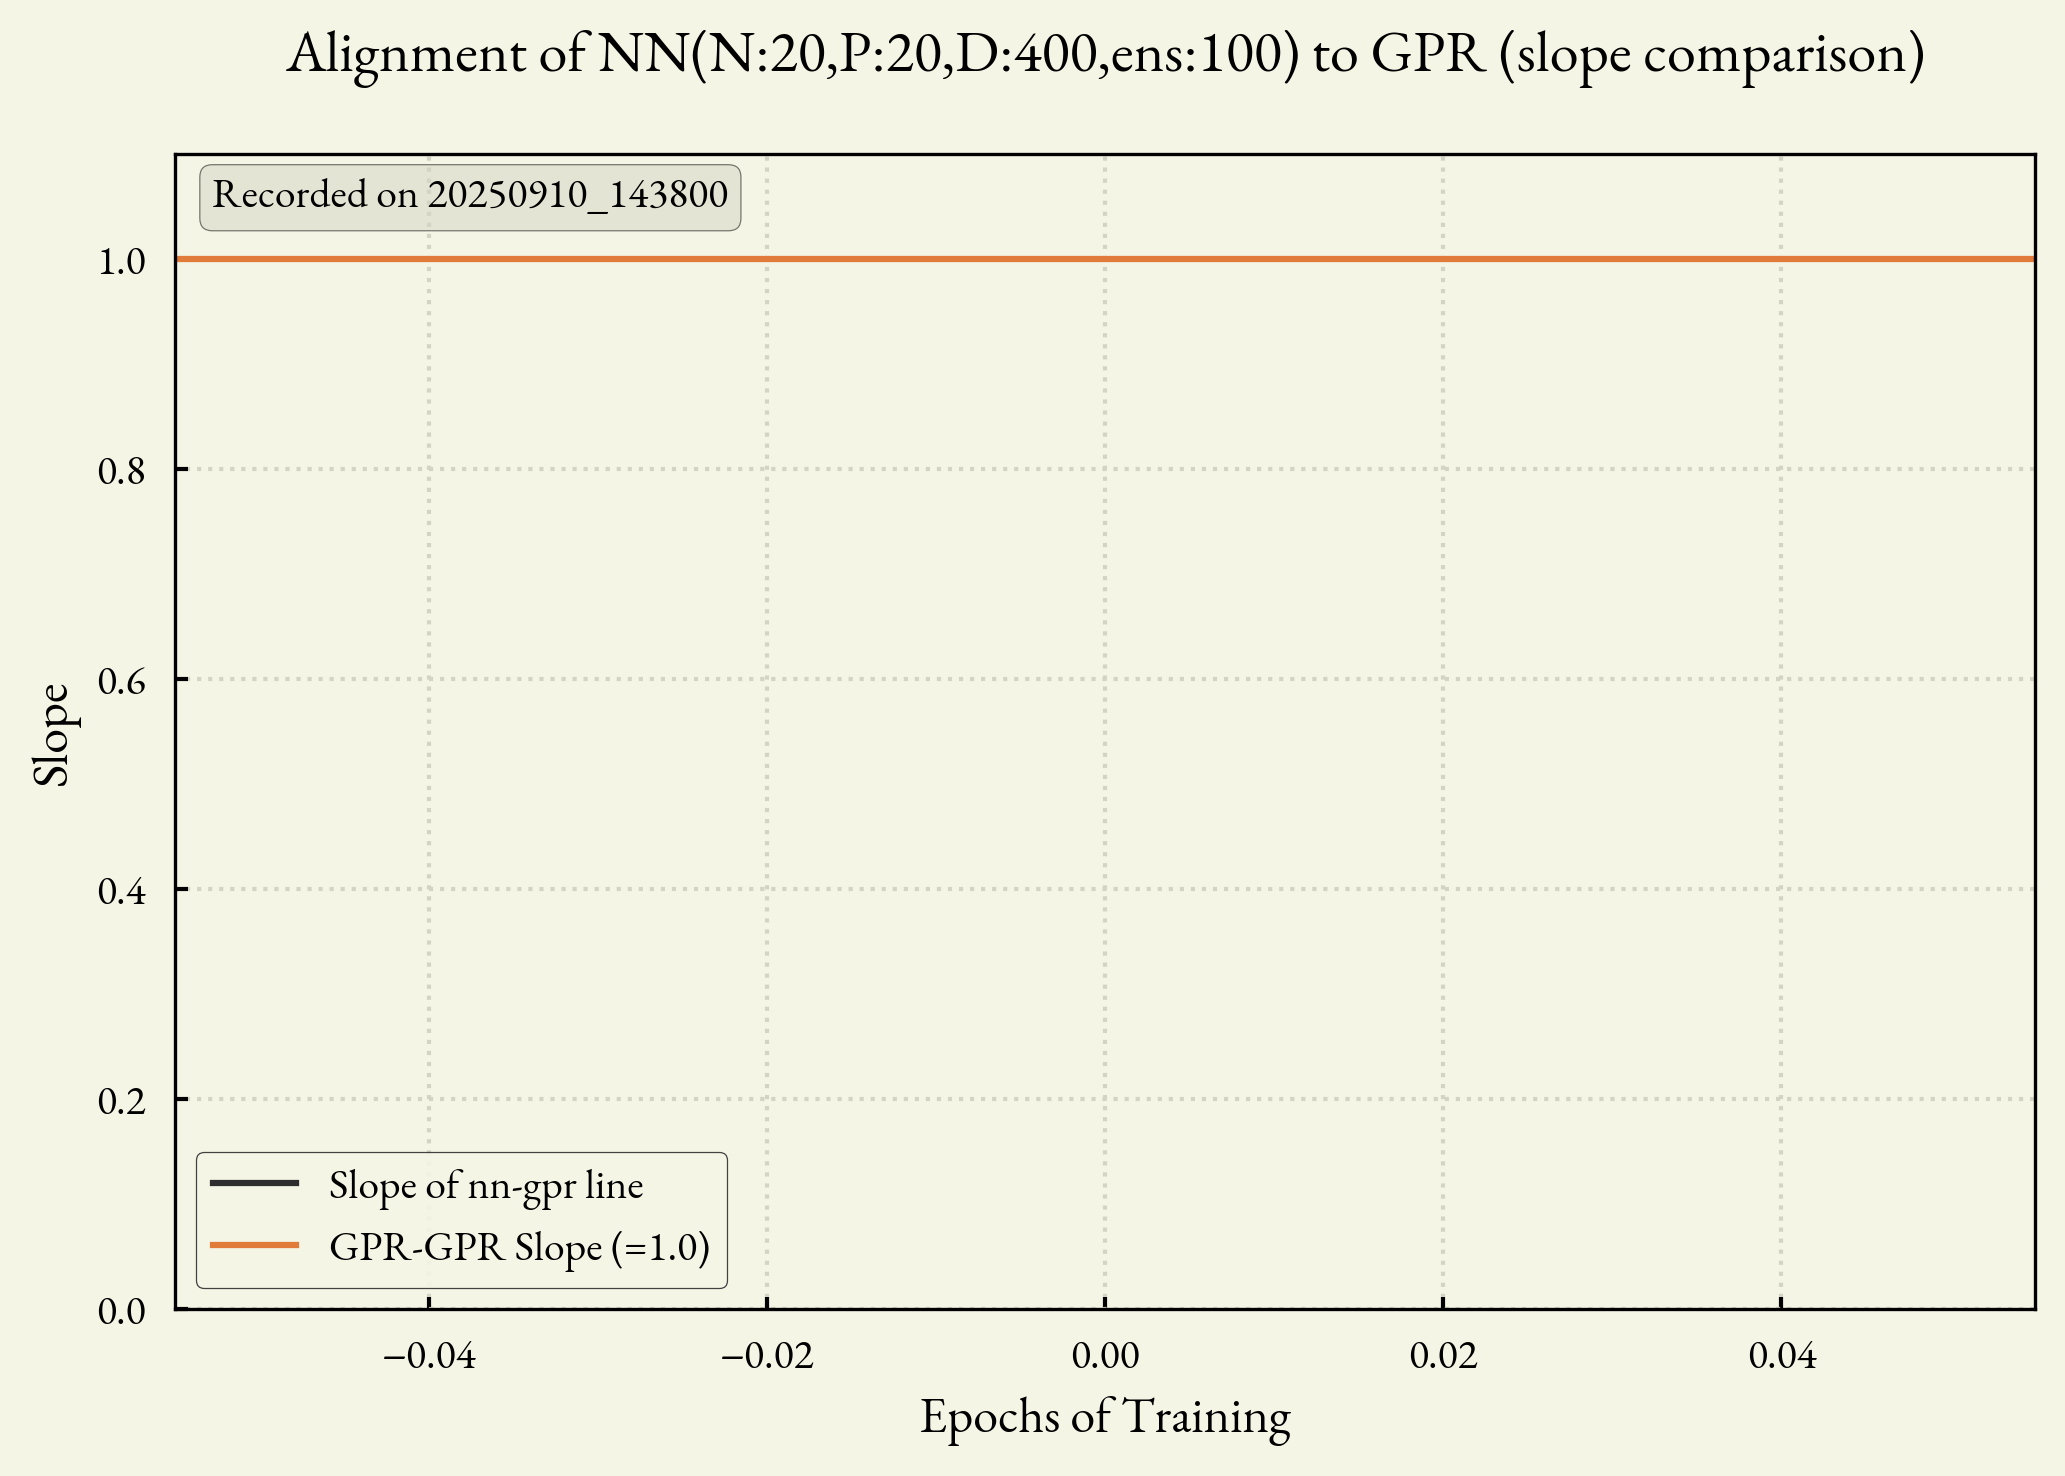

In [53]:
# Ensure Matplotlib recognizes the custom font
from matplotlib import font_manager
font_path = '/home/akiva/fonts/EBGaramond.ttf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'EB Garamond'

# Custom Victorian style
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams.update({
    'font.size': 12,
    'axes.facecolor': '#f5f5e6',  # Parchment background
    'figure.facecolor': '#f5f5e6',
    'grid.color': '#d4d4c4',
    'grid.linestyle': ':',
    'lines.linewidth': 1.5,
})

plt.figure(figsize=(8, 5))
plt.plot(epochs_sorted, slopes_sorted, marker='x', linestyle='-', color='#2e2e2e', label='Slope of nn-gpr line')
# plt.axhline(y=true_slope, color='#355e3b', linestyle='--', label=f'True Slope = {true_slope:.2f}')
plt.axhline(y=m_gpr, color='#e07b39', linestyle='-', label='GPR-GPR Slope (=1.0)')
plt.title('Alignment of NN(N:20,P:20,D:400,ens:100) to GPR (slope comparison)', fontsize=14, pad=20)
plt.xlabel('Epochs of Training', fontsize=12)
plt.ylabel('Slope', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True)
from datetime  import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.legend(frameon=True, framealpha=0.9, edgecolor='#2e2e2e')
plt.text(0.02, 0.98, f'Recorded on {timestamp}', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#d4d4c4', alpha=0.5))
# plt.savefig(os.path.join(save_dir, f"slope_epoch_{epoch+1}.png"), dpi=300, bbox_inches='tight')
# writer.add_figure('Slope/Over_Epochs', plt.gcf(), global_step=epoch)
# plt.close()

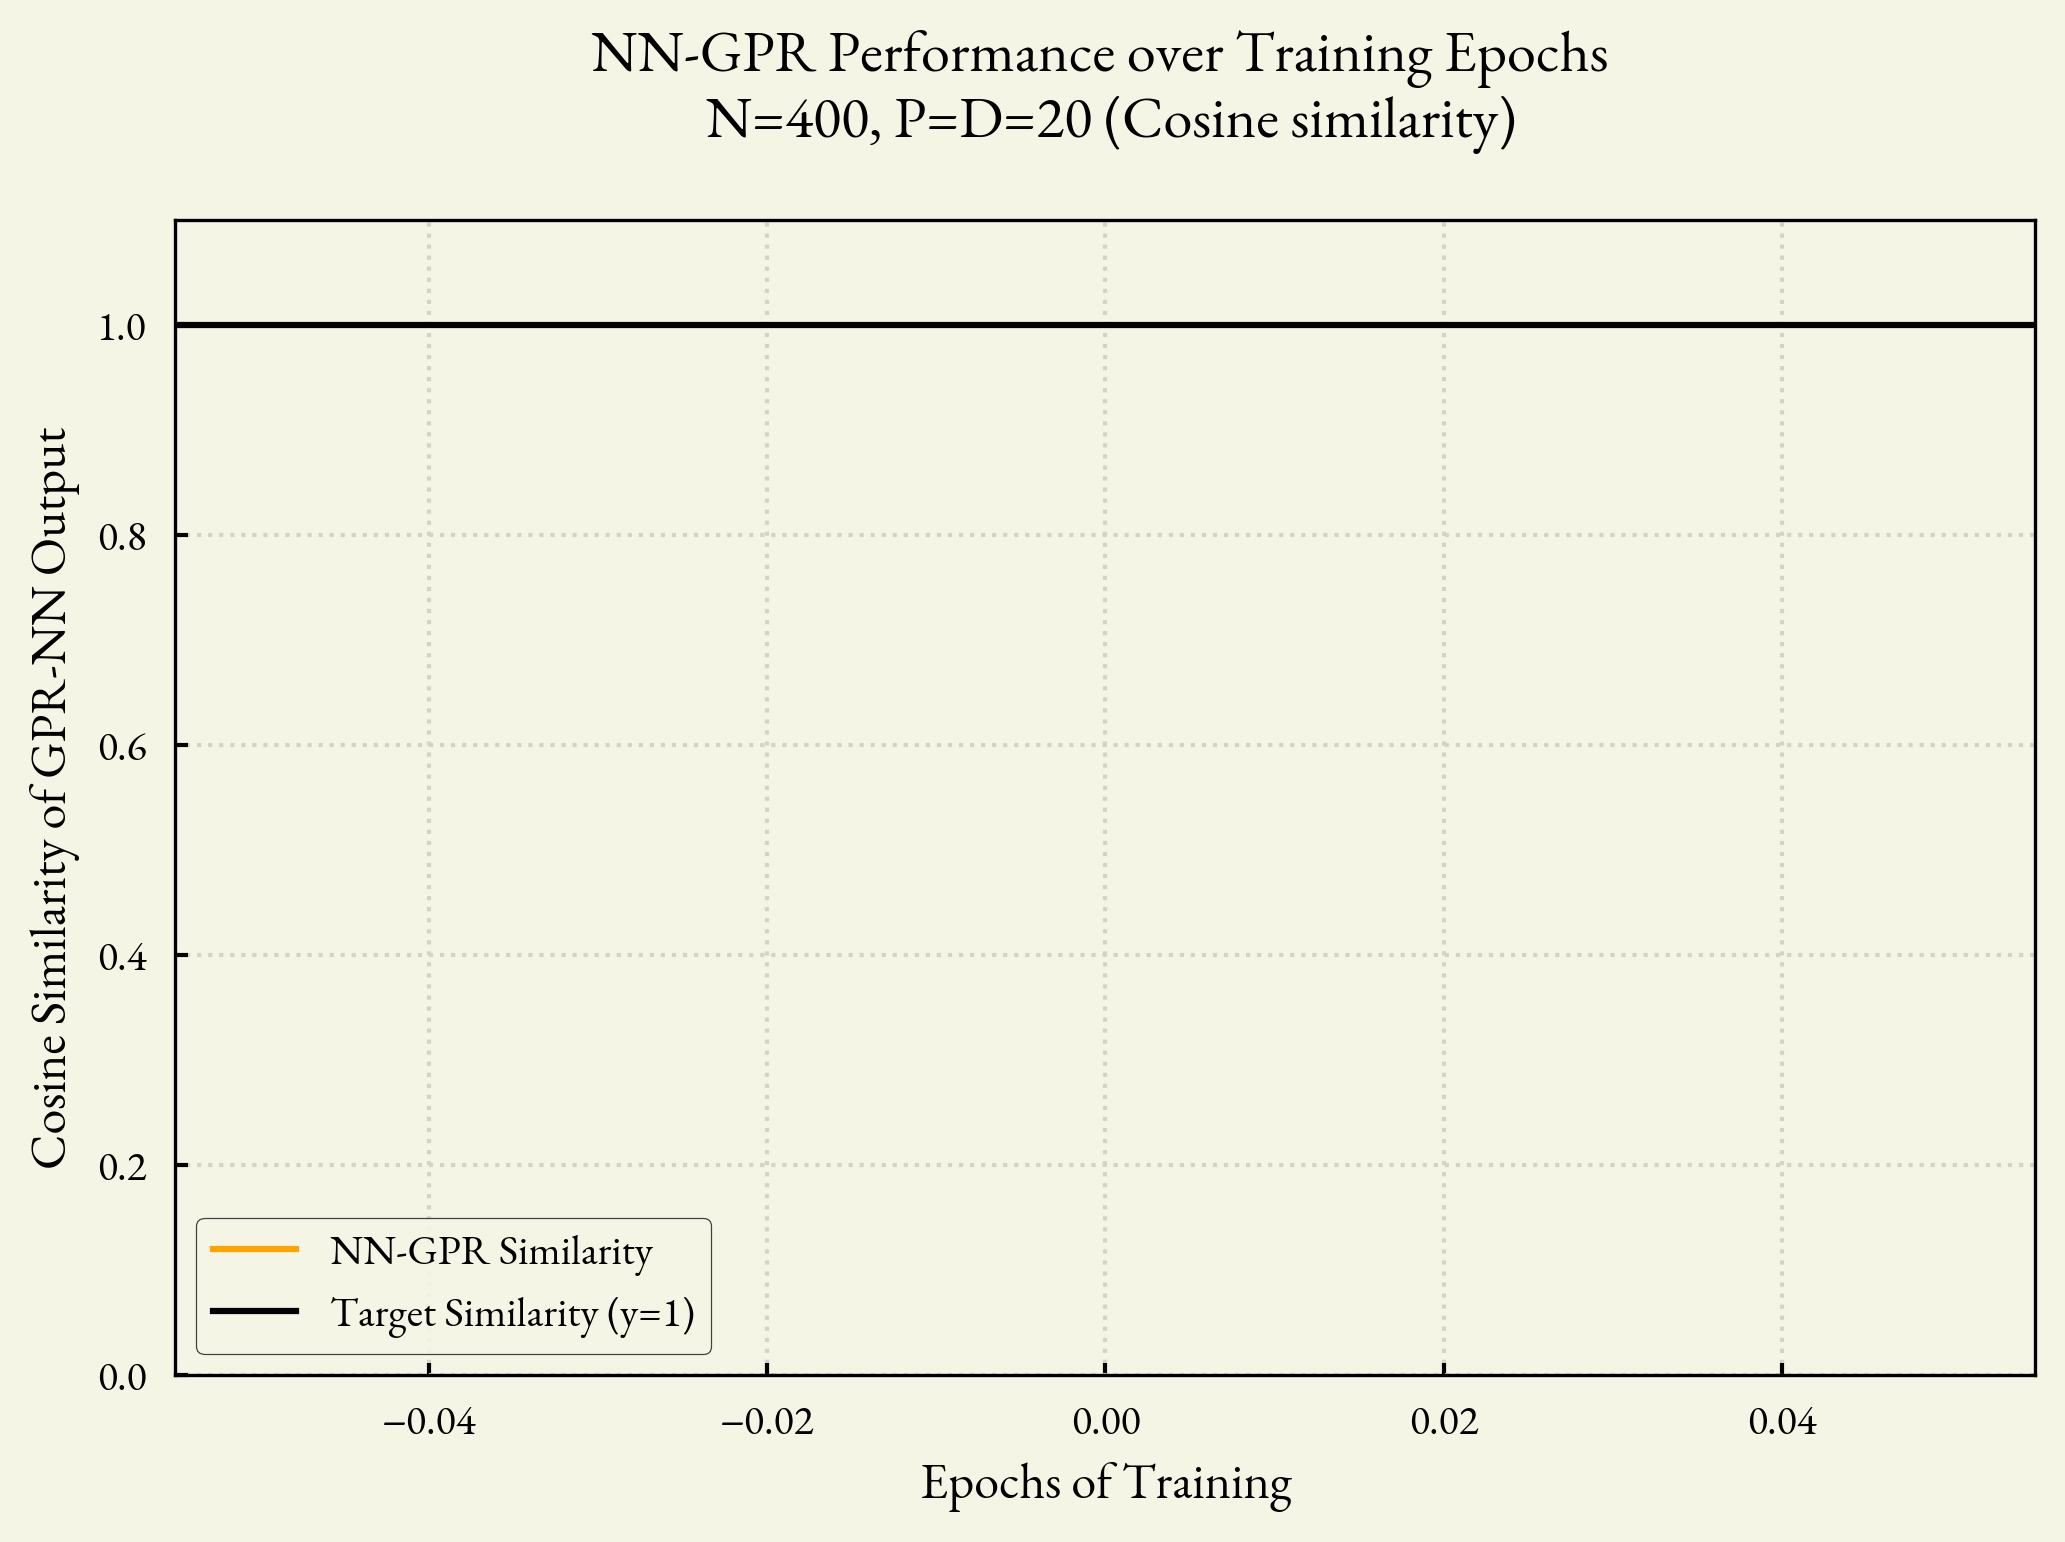

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_sorted, cos_sorted, linestyle='-', color='orange', label='NN-GPR Similarity')
plt.axhline(y=1.0, color='black', linestyle='-', linewidth=1.5, label='Target Similarity (y=1)')
plt.title('NN-GPR Performance over Training Epochs \n N=400, P=D=20 (Cosine similarity)', fontsize=14, pad=20)
plt.xlabel('Epochs of Training', fontsize=12)
plt.ylabel('Cosine Similarity of GPR-NN Output', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend(frameon=True, framealpha=0.9, edgecolor='#2e2e2e')
plt.show()

In [23]:
1

1